# Importing the required libraries.

In [2]:
import fenics as fe

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np

# Stefan Problem

                                     We need to solve the energy equation,
     
                                             𝜌(𝜕𝑡ℎ+𝑢∙∇ℎ)=𝑘∆T.
         
                                                     where 𝜌 = density
                                                               
                                                     𝜕𝑡ℎ = derivative of enthalpy with respect 
                                                     to temperature 
                                                       
                                                     𝑢= velocity of the fluid in consideration  
                                    
                                     For the stefan problem, the following assumptions are made:
                                <ul>
                                <li>The specific heat capacity is constant.</li>
                                <li> $u.∇(\phi)$= small and negligible</li>
                                </ul>

                                     Writing it in weak form, here v is the test function
     
                                             (𝑣,𝜕𝑡ℎ)=−𝑑𝑇/𝑑ℎ(𝑘/𝜌)(∇𝑣,∇ℎ)

                                     Since it is a non-linear problem,
      
                                      F= (𝑣,𝜕𝑡ℎ)+𝑑𝑇/𝑑ℎ (𝑘/𝜌)(∇𝑣,∇ℎ)=0
      
                                     is solved by newton's method.
       

f_265


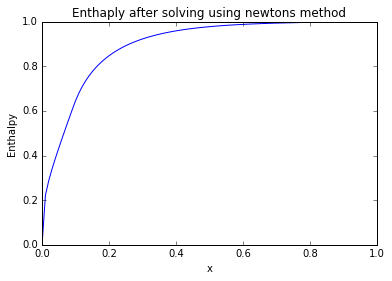

In [9]:
Mesh_size=100     #Taking the mesh size to be 100
L=1.01/0.045      #The latent heat of fusion of ice. Stefan number is 0.045
mesh = fe.UnitIntervalMesh(Mesh_size) #One Dimensional mesh
P1 = fe.FiniteElement('P', mesh.ufl_cell(), 1)
V = fe.FunctionSpace(mesh, P1)  #Function space spanned by piecewise linear polynomials
v = fe.TestFunction(V)   #Test function
h = fe.Function(V)       #Enthalpy-Trial function
ste=fe.Constant(0.045)   #Stefan Number
prandl_number=fe.Constant(1)
rho=1     #Density
K=1       #thermal conductivity
c=1       #Specific heat of capacity
def phis(h):      #Function phi in terms of enthalpy
	r=0.025       #smoothing parameter  
	return 0.5*(1. + fe.tanh((-h)/r)) 
def T(h):     #Temperature as a function of enthalpy
	return c*(h**3)    # Approximating the fuction to be cubic such that it closely resemble the physics of the problem
T=T(h)
phi_h=phis(h)
#Boundary conditions and interpolating the values in between
hot_wall_enthalpy = 0
h_h = fe.Constant(hot_wall_enthalpy)
cold_wall_enthalpy = c
h_c = fe.Constant(cold_wall_enthalpy)
initial_melt_thickness = 10./float(Mesh_size)
h_n = fe.interpolate(                               #Interpolating the values in between the two extreme boundary walls.
    fe.Expression(
        "(h_h - h_c)*(x[0] < x_m0) + h_c",
        h_h = hot_wall_enthalpy, 
        h_c = cold_wall_enthalpy,
        x_m0 = initial_melt_thickness,
        element = P1),
    V)
timestep_size = 1.e-2
Delta_t = fe.Constant(timestep_size)                   #Time difference to be taken as constant of 10e-2
T_t = (T )/Delta_t
phi_t = (phis(h) - phis(h))/Delta_t                    #{d\phi}/{d\t}
h_t=(h-h_n)/Delta_t                                    #{d\h}/{d\t} but as piecewise as we know the intermediate values   
diffth=3*c*(h**2)                                      #{d\T}/{d\h} Simple gateaux derivative of the c*h^3 function
F=(diffth*(fe.dot(fe.grad(v),fe.grad(h)))+(rho/K)*(v*h_t))*fe.dx    #The nonlinear function to be solved is assembled
JF = fe.derivative(F, h, fe.TrialFunction(V))       #Taking the derivative of the non linear function to solve by newton's method
#Setting the boundary conditions to capture the values near the boundary too as we are working in inexact arithmetic.
hot_wall = "near(x[0],  0)"
cold_wall = "near(x[0],  1.0)"
hot_enthalpy=0
cold_enthalpy=c
boundary_conditions = [
fe.DirichletBC(V, hot_enthalpy, hot_wall),
fe.DirichletBC(V, cold_enthalpy, cold_wall)]
#Invoking the Newton's method
problem = fe.NonlinearVariationalProblem(F, h, boundary_conditions, JF)
solver = fe.NonlinearVariationalSolver(problem)
solver.solve()
#Printing and plotting the solution
print(h)
fe.plot(h)
plt.xlabel('x')
plt.ylabel('Enthalpy')
plt.title('Enthaply after solving using newton''s method')
plt.show()

